In [1]:
import glob
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_dataframe_from_dir(path, ext, ignore_idx=False, save_file=False):
    df = pd.DataFrame()
    if ext != 'csv':
        return df
    
    csv_files = glob.glob(path + f"/*.{ext}")
    df_list = (pd.read_csv(file) for file in csv_files)
    get_next = peek(df_list)

    if get_next is None:
        print("***** empty dataframe *****")
        return df
    
    df = pd.concat(df_list, ignore_index=ignore_idx)
    if save_file:
        df.to_csv('merged.csv')
    if 'time' in df.columns:
        df.set_index("time", drop=True, append=False, inplace=True)
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    else:
        df.sort_index(axis=0, ascending=True, inplace=True, ignore_index=False)
    
    return df


def peek(iterable):
    try:
        first = next(iterable)
    except StopIteration:
        return None
    return first, itertools.chain([first], iterable)


In [5]:
df = get_dataframe_from_dir("../__data__/xaiops_metric/was/214(04.01~07.10)", "csv", save_file=True)
# df = df.sample(frac=0.01)

# remove low variance column
for column in df.columns:
    if df[column].mean() == 0:
        df.drop(columns=[column], inplace=True)

# remove rows having NaN value
df.dropna(axis=0, inplace=True)

# sort index
df.sort_index(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 143908 entries, 2022-04-01 00:00:00 to 2022-07-10 23:59:00
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   active_db_conn_count  143908 non-null  float64
 1   active_tx_count       143908 non-null  float64
 2   active_users          143908 non-null  float64
 3   call_count            143908 non-null  float64
 4   cpu_time              143908 non-null  float64
 5   cpu_usage             143908 non-null  float64
 6   db_sessions           143908 non-null  float64
 7   fetch_count           143908 non-null  float64
 8   fgc                   143908 non-null  float64
 9   fgct                  143908 non-null  float64
 10  file_count            143908 non-null  float64
 11  gc_count              143908 non-null  float64
 12  gc_time               143908 non-null  float64
 13  heap_usage            143908 non-null  float64
 14  jvm_free_heap         1439

In [7]:
df.describe()

active_db_conn_count  active_tx_count   active_users     call_count  \
count         143908.000000    143908.000000  143908.000000  143908.000000   
mean               0.348671         6.116735       1.123234      10.235244   
std                0.855621        35.363078       0.432208       8.803050   
min                0.000000         0.000000       0.000000       0.000000   
25%                0.000000         0.150000       0.800000       2.650000   
50%                0.100000         0.550000       1.200000       8.950000   
75%                0.300000         2.000000       1.450000      14.900000   
max                8.700000       300.000000       2.100000      57.100000   

            cpu_time      cpu_usage    db_sessions    fetch_count  \
count  143908.000000  143908.000000  143908.000000  143908.000000   
mean        2.639522       1.714815       8.978568      28.625452   
std         3.062439       1.482093       0.332399      25.889013   
min         0.144000       0.000000       1.000000       0.000000   
25%         0.483000       0.300000       9.000000       6.100000   
50%         0.900500       1.600000       9.000000      24.500000   
75%         4.475000       2.650000       9.000000      42.150000   
max        14.845000      11.550000       9.800000     217.950000   

                 fgc           fgct  ...  prepare_count  response_time  \
count  143908.000000  143908.000000  ...  143908.000000  143908.000000   
mean        0.008777       1.226144  ...      63.995737     199.173090   
std         0.019025       2.671285  ...      56.854849     797.986026   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...      13.650000      29.284600   
50%         0.000000       0.000000  ...      55.200000      35.963400   
75%         0.000000       0.000000  ...      94.650000      64.528375   
max         0.166667      24.333333  ...     315.250000  141017.833300   

           sql_count       sql_time            tgc           tgct  \
count  143908.000000  143908.000000  143908.000000  143908.000000   
mean       63.995737     694.231591       1.031402       9.384380   
std        56.854849    1233.171588       0.670284       6.831776   
min         0.000000       0.000000       0.000000       0.000000   
25%        13.650000      85.450000       0.350000       2.450000   
50%        55.200000     292.000000       1.150000      10.050000   
75%        94.650000     760.512500       1.600000      14.050000   
max       315.250000   79966.600000      14.833300     154.500000   

        thread_count            tps            ygc           ygct  
count  143908.000000  143908.000000  143908.000000  143908.000000  
mean      143.778884       9.979260       1.022626       8.158237  
std        42.934727       8.751367       0.663397       5.422465  
min        39.600000       0.000000       0.000000       0.000000  
25%       119.950000       2.449900       0.300000       2.350000  
50%       142.000000       8.666600       1.150000       9.400000  
75%       155.450000      14.600000       1.600000      13.000000  
max       406.000000      48.699900      14.666667     130.166667  

[8 rows x 32 columns]

In [8]:
def get_threshold(m, std):
    upper = m + 3*std
    lower = m - 3*std
    return upper, lower


In [10]:
static_values = {}
columns = df.columns
for column in columns:
    if column not in static_values:
        static_values[column] = {}
    
    mean = df[column].mean()
    std = df[column].std()
    var = df[column].var()
    static_values[column]['mean'] = mean
    static_values[column]['std'] = std

    threshold = get_threshold(mean, std)
    static_values[column]['upper'] = threshold[0]
    static_values[column]['lower'] = threshold[1]
    static_values[column]['var'] = var

static_values['active_db_conn_count']['mean'] == df['active_db_conn_count'].mean()


True

/home/aiops/anaconda3/envs/tf/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical left == right == 32641244.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/aiops/anaconda3/envs/tf/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical bottom == top == 32641244.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/aiops/anaconda3/envs/tf/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical left == right == 32641244.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


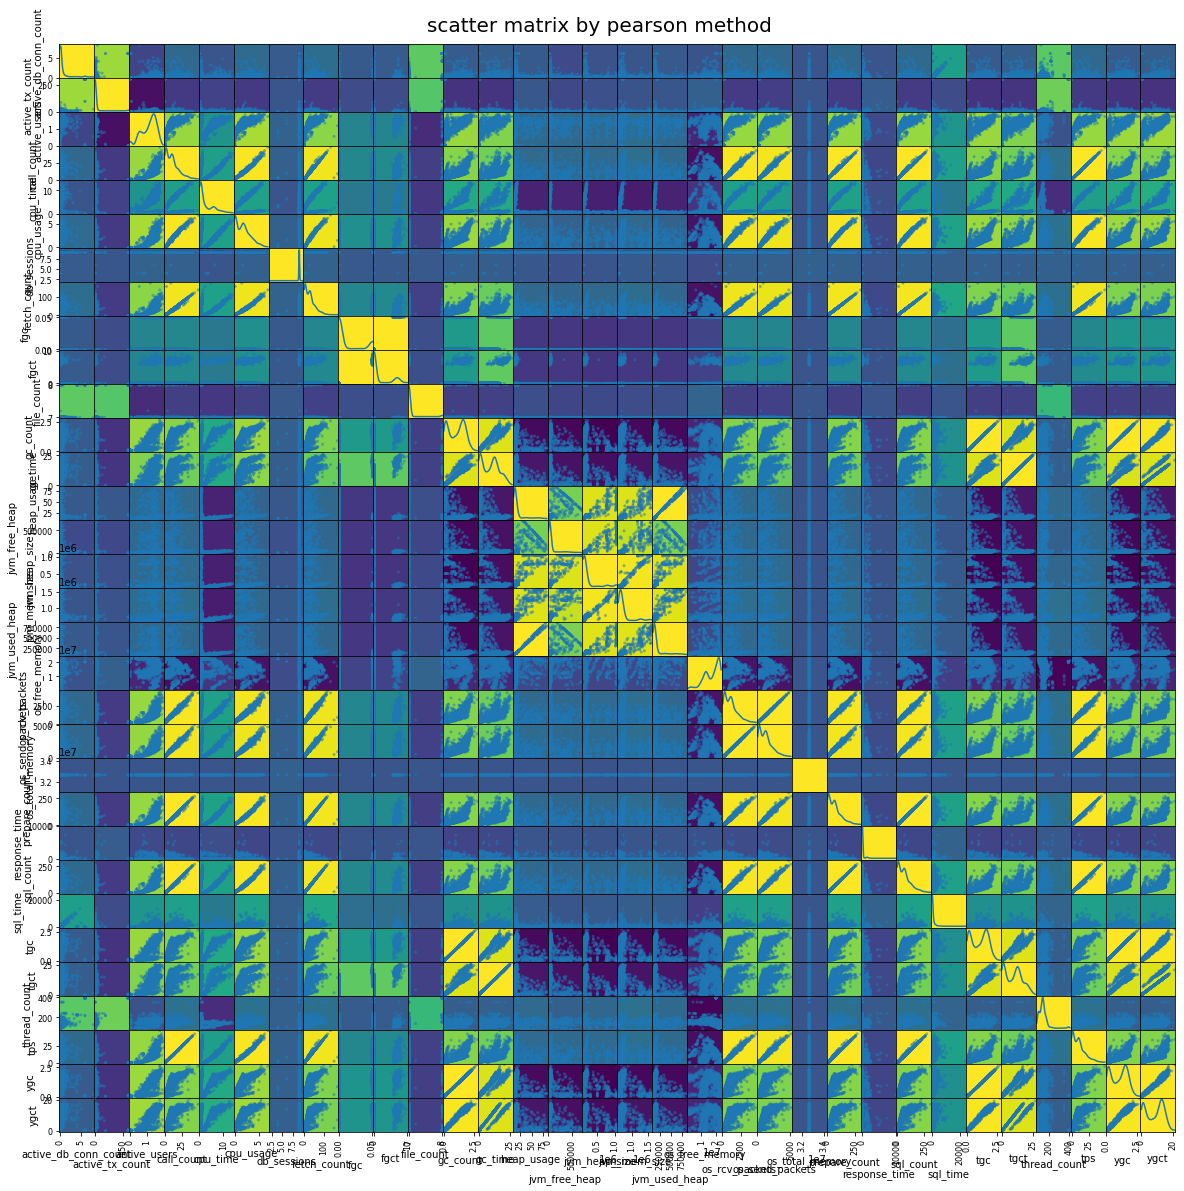

/home/aiops/anaconda3/envs/tf/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/home/aiops/anaconda3/envs/tf/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4869: RuntimeWarning: invalid value encountered in sqrt
  z = con_minus_dis / np.sqrt(var)


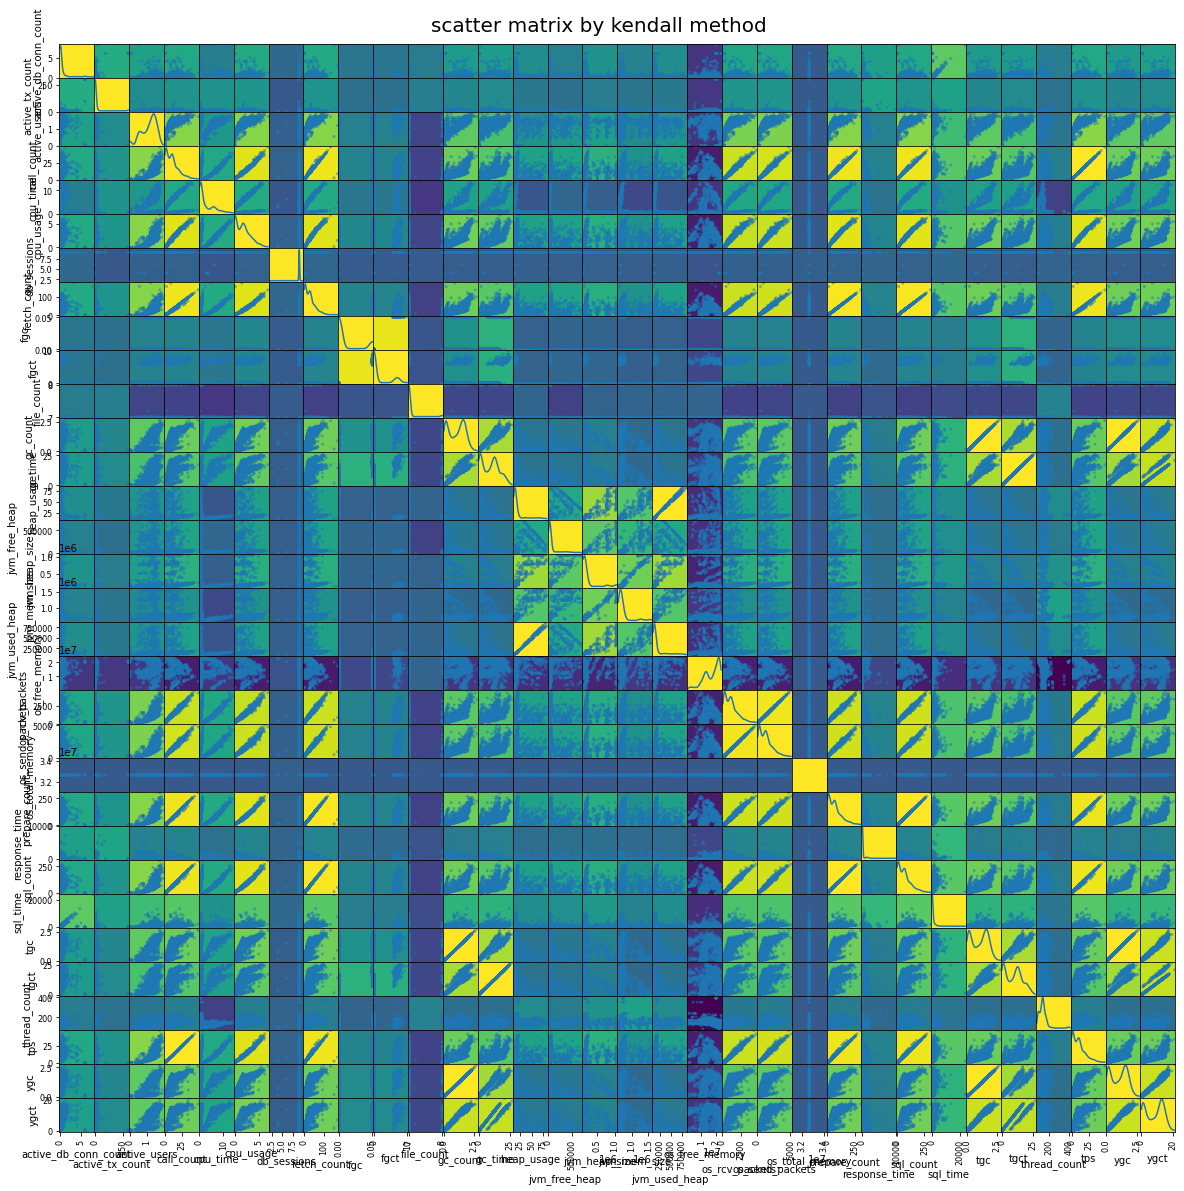

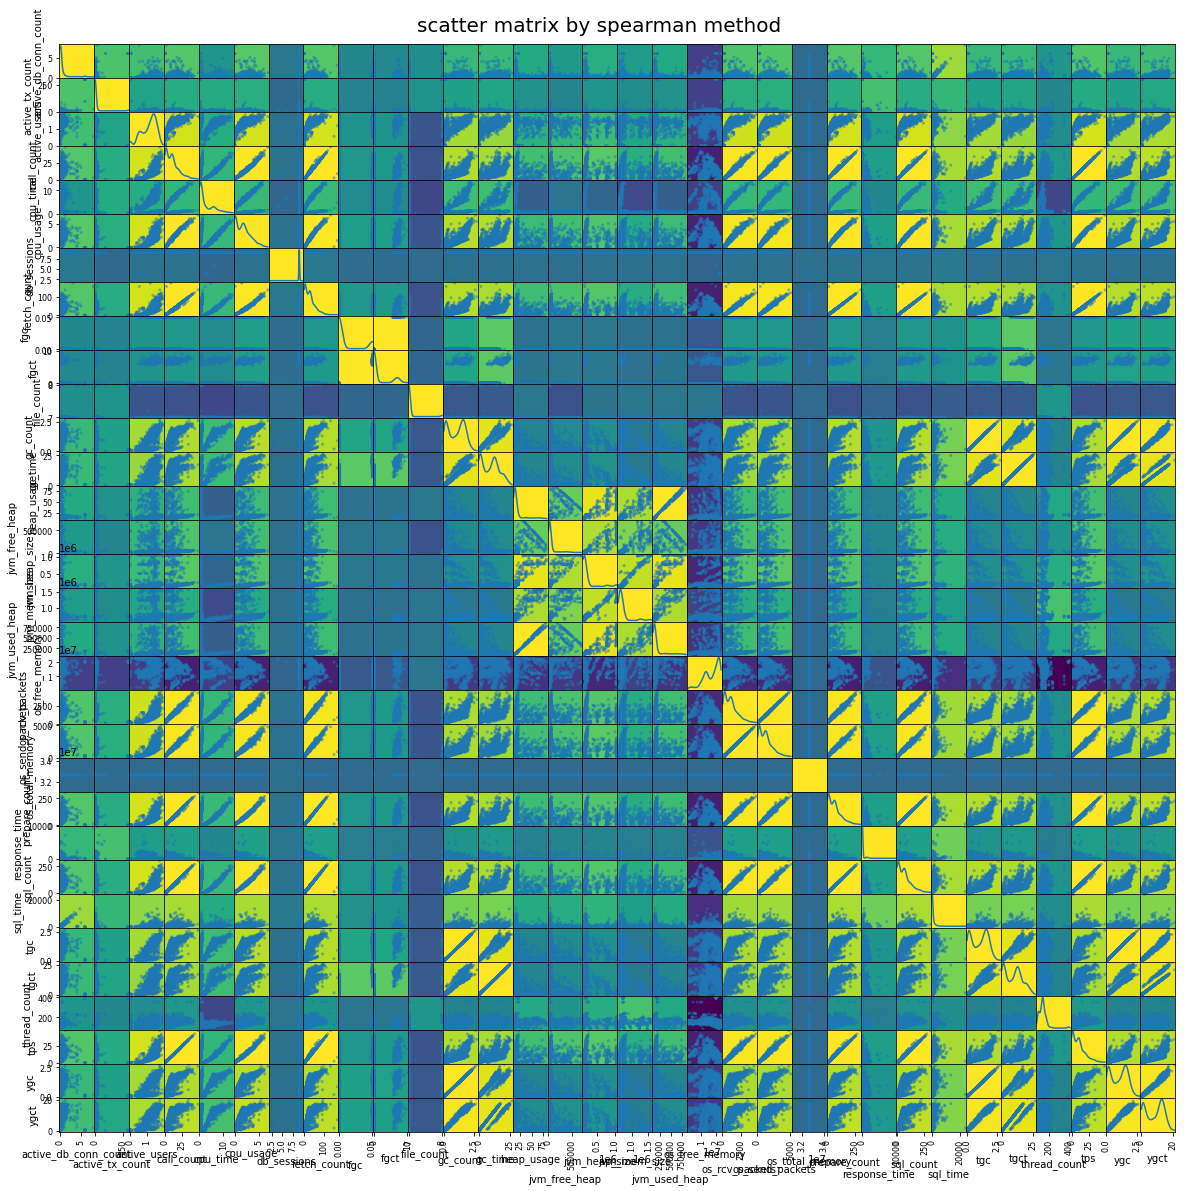

In [11]:
# draw scatter matrix by pandas&pyplot
meta = {
    'pearson': 'pearson', 
    'kendall': 'kendall', 
    'spearman': 'spearman'
}

df_sampled = df.sample(frac=0.01, axis=0, random_state=1)

for key in meta.keys():    
    axes = pd.plotting.scatter_matrix(
        df_sampled, 
        figsize=(20,20), 
        alpha=0.5,
        diagonal='kde'
    )
    plt.suptitle(
        'scatter matrix by ' + meta[key] + ' method', 
        y=0.9, 
        fontsize=20
    )

    corr = df.corr(method=str(key)).values
    corr_norm = (corr - corr.min())/(corr.max() - corr.min())

    # set each axe color
    for i, ax in enumerate(axes.flatten()):
        c = plt.cm.viridis(corr_norm.flatten()[i])
        ax.set_facecolor(c)
    
    plt.show()


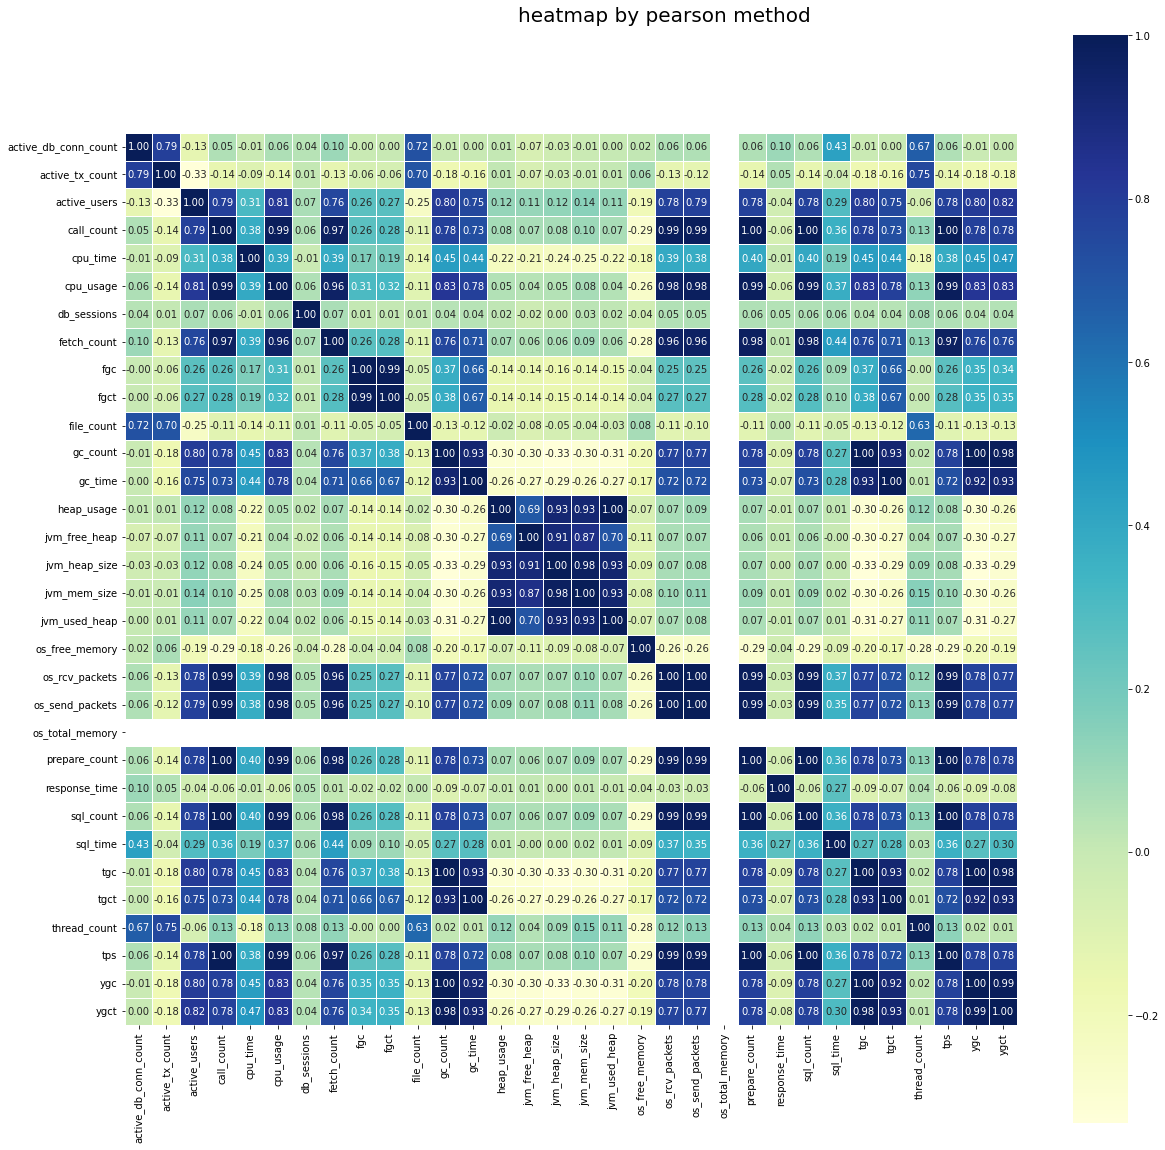

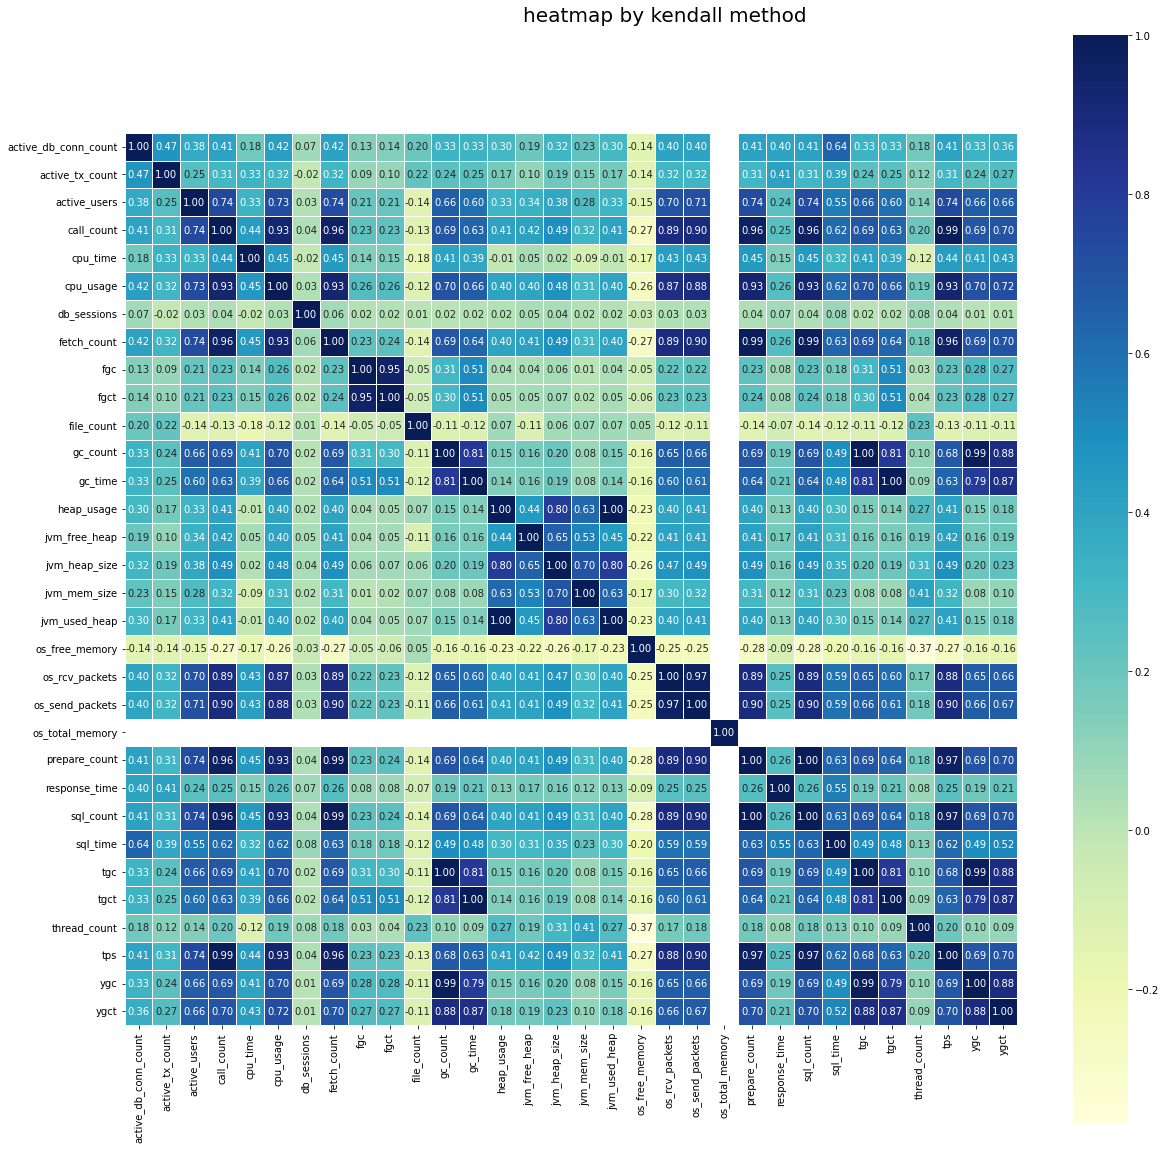

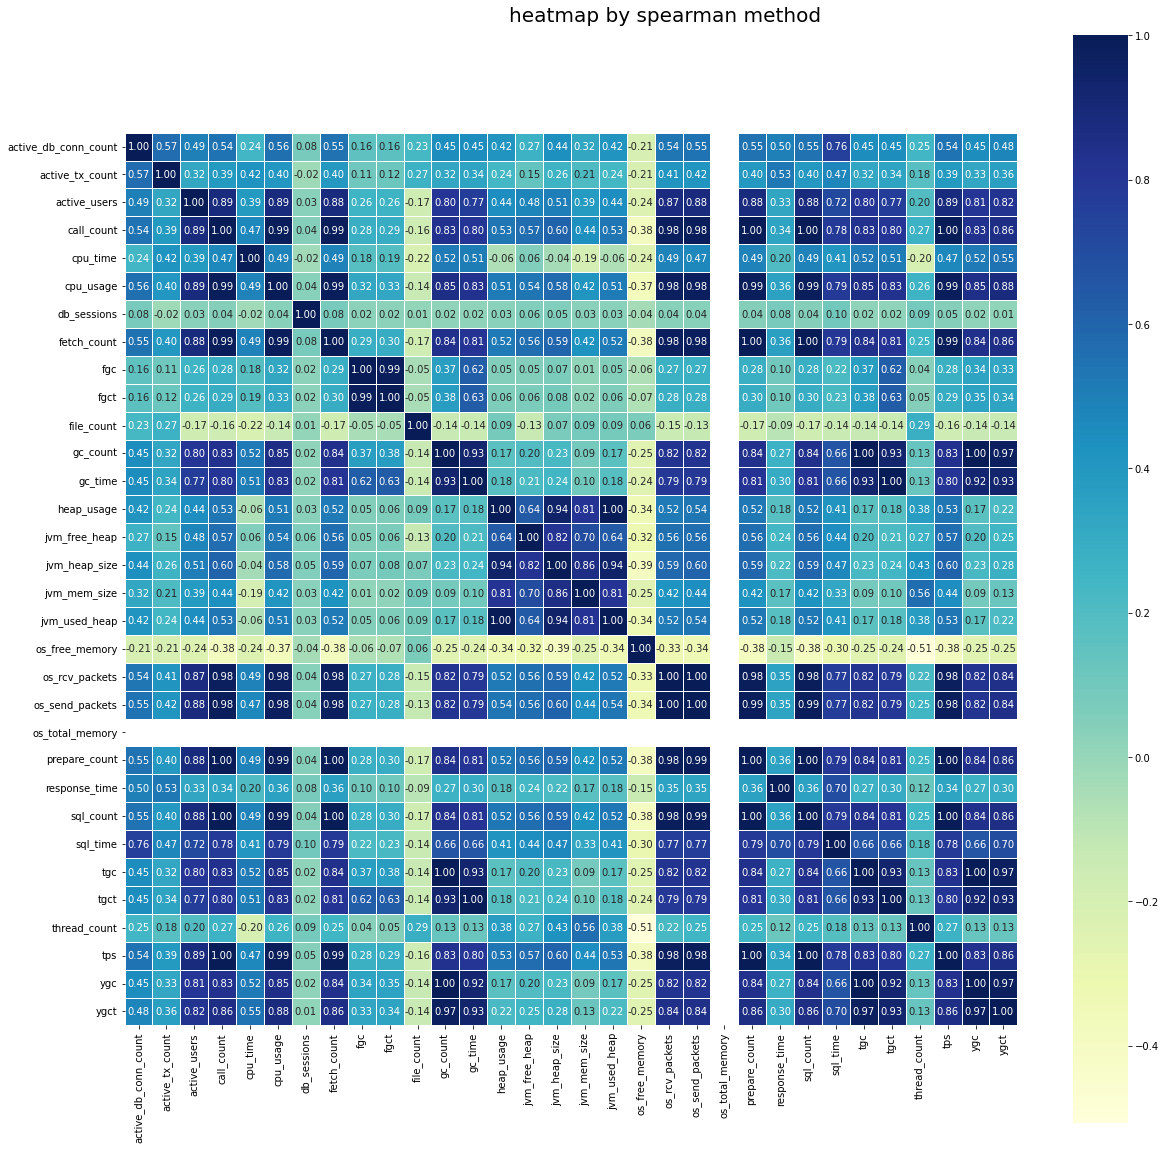

In [12]:
# draw heatmap
for key in meta.keys():
    plt.subplots(figsize=(20, 20))
    sns.heatmap(
        df_sampled.corr(method=meta[key]), 
        annot=True, 
        fmt=".2f", 
        cmap="YlGnBu", 
        cbar=True, 
        square=True, 
        linewidths=.5
    )
    
    plt.suptitle(
            'heatmap by ' + meta[key] + ' method', 
            y=0.9, 
            fontsize=20
        )
    plt.show()

In [13]:
def get_corr_values_by_method(df, method):
    return df.corr(method=method)

for key in meta.keys():
    corr = get_corr_values_by_method(df_sampled.iloc[:, :4], meta[key])
    print(f'****** corr values by {meta[key]} ******')
    print(f'{corr}\n\n')


****** corr values by pearson ******
                      active_db_conn_count  active_tx_count  active_users  \
active_db_conn_count              1.000000         0.790319     -0.132386   
active_tx_count                   0.790319         1.000000     -0.327053   
active_users                     -0.132386        -0.327053      1.000000   
call_count                        0.054471        -0.140509      0.785079   

                      call_count  
active_db_conn_count    0.054471  
active_tx_count        -0.140509  
active_users            0.785079  
call_count              1.000000  


****** corr values by kendall ******
                      active_db_conn_count  active_tx_count  active_users  \
active_db_conn_count              1.000000         0.469032      0.377092   
active_tx_count                   0.469032         1.000000      0.252350   
active_users                      0.377092         0.252350      1.000000   
call_count                        0.409613         0.30

In [14]:
corr_matrix = df.corr()
corr_matrix

active_db_conn_count  active_tx_count  active_users  \
active_db_conn_count              1.000000         0.802882     -0.075054   
active_tx_count                   0.802882         1.000000     -0.296873   
active_users                     -0.075054        -0.296873      1.000000   
call_count                        0.100224        -0.123942      0.790211   
cpu_time                         -0.000005        -0.084217      0.342160   
cpu_usage                         0.110451        -0.123041      0.820816   
db_sessions                       0.030596         0.007977      0.072055   
fetch_count                       0.126701        -0.116878      0.766842   
fgc                               0.024333        -0.044944      0.257258   
fgct                              0.027870        -0.043684      0.262964   
file_count                        0.665285         0.637161     -0.189218   
gc_count                          0.030612        -0.156905      0.792936   
gc_time                           0.046372        -0.143175      0.744115   
heap_usage                        0.026757         0.015313      0.101339   
jvm_free_heap                    -0.051055        -0.060472      0.100205   
jvm_heap_size                    -0.014931        -0.025543      0.107355   
jvm_mem_size                      0.007002        -0.009921      0.126264   
jvm_used_heap                     0.021060         0.010754      0.099609   
os_free_memory                   -0.009303         0.054982     -0.214624   
os_rcv_packets                    0.099436        -0.117151      0.787170   
os_send_packets                   0.098815        -0.108798      0.782352   
os_total_memory                   0.001074         0.000456      0.006241   
prepare_count                     0.103860        -0.119494      0.784953   
response_time                    -0.003127         0.042356     -0.048683   
sql_count                         0.103860        -0.119494      0.784953   
sql_time                          0.397996        -0.042898      0.350094   
tgc                               0.030612        -0.156905      0.792936   
tgct                              0.046372        -0.143175      0.744115   
thread_count                      0.655179         0.700038     -0.015106   
tps                               0.102247        -0.121416      0.787086   
ygc                               0.030232        -0.157245      0.793791   
ygct                              0.044695        -0.158866      0.807968   

                      call_count  cpu_time  cpu_usage  db_sessions  \
active_db_conn_count    0.100224 -0.000005   0.110451     0.030596   
active_tx_count        -0.123942 -0.084217  -0.123041     0.007977   
active_users            0.790211  0.342160   0.820816     0.072055   
call_count              1.000000  0.398693   0.987844     0.057361   
cpu_time                0.398693  1.000000   0.417707     0.001518   
cpu_usage               0.987844  0.417707   1.000000     0.057870   
db_sessions             0.057361  0.001518   0.057870     1.000000   
fetch_count             0.972595  0.408367   0.964702     0.066029   
fgc                     0.272385  0.190048   0.313522     0.017116   
fgct                    0.287427  0.201425   0.327212     0.017355   
file_count             -0.100055 -0.136958  -0.094092     0.017745   
gc_count                0.752837  0.465897   0.801593     0.049196   
gc_time                 0.708249  0.464333   0.768868     0.045485   
heap_usage              0.108742 -0.221762   0.076668     0.016317   
jvm_free_heap           0.101775 -0.212791   0.061757    -0.025778   
jvm_heap_size           0.110623 -0.233609   0.071776    -0.003610   
jvm_mem_size            0.136112 -0.249564   0.100562     0.023392   
jvm_used_heap           0.104033 -0.221699   0.071524     0.017727   
os_free_memory         -0.301545 -0.149298  -0.289121    -0.041889   
os_rcv_packets          0.987153  0.409326   0.977500     0.051432   
os_send_pa

In [15]:
# get high corr metrics
df_sampled = df.sample(frac=0.1, axis=0, random_state=1)
corr = get_corr_values_by_method(df_sampled, 'kendall')
high_corr_items = []
threshold = 0.9
for i in corr.index:
    for column in corr.columns:
        corr_value = corr[i][column]
        if abs(corr_value) >= 0.9 and abs(corr_value) != 1.0:
            high_corr_items.append([i, column, corr[i][column]])

print(len(high_corr_items))
high_corr_items

54


[['call_count', 'cpu_usage', 0.9333001055125364],
 ['call_count', 'fetch_count', 0.9638605162497175],
 ['call_count', 'os_send_packets', 0.9041913312313121],
 ['call_count', 'prepare_count', 0.966207320493097],
 ['call_count', 'sql_count', 0.9662072917770286],
 ['call_count', 'tps', 0.9923691708992178],
 ['cpu_usage', 'call_count', 0.9333001055125364],
 ['cpu_usage', 'fetch_count', 0.9333078277324736],
 ['cpu_usage', 'prepare_count', 0.9358415606506094],
 ['cpu_usage', 'sql_count', 0.9358415319744277],
 ['cpu_usage', 'tps', 0.932812752560374],
 ['fetch_count', 'call_count', 0.9638605162497175],
 ['fetch_count', 'cpu_usage', 0.9333078277324736],
 ['fetch_count', 'os_send_packets', 0.9003391029222464],
 ['fetch_count', 'prepare_count', 0.9885570149519471],
 ['fetch_count', 'sql_count', 0.988557227947312],
 ['fetch_count', 'tps', 0.9648414366644078],
 ['fgc', 'fgct', 0.9505808745478178],
 ['fgct', 'fgc', 0.9505808745478178],
 ['gc_count', 'tgc', 0.9999732006440021],
 ['gc_count', 'ygc', 0

<AxesSubplot:xlabel='time', ylabel='prepare_count'>

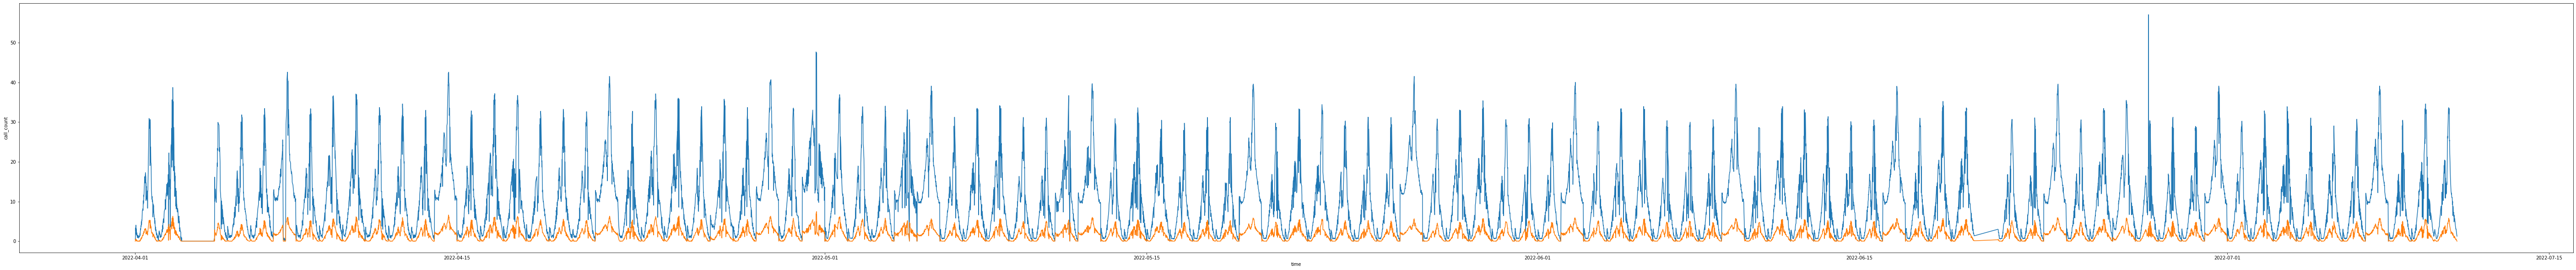

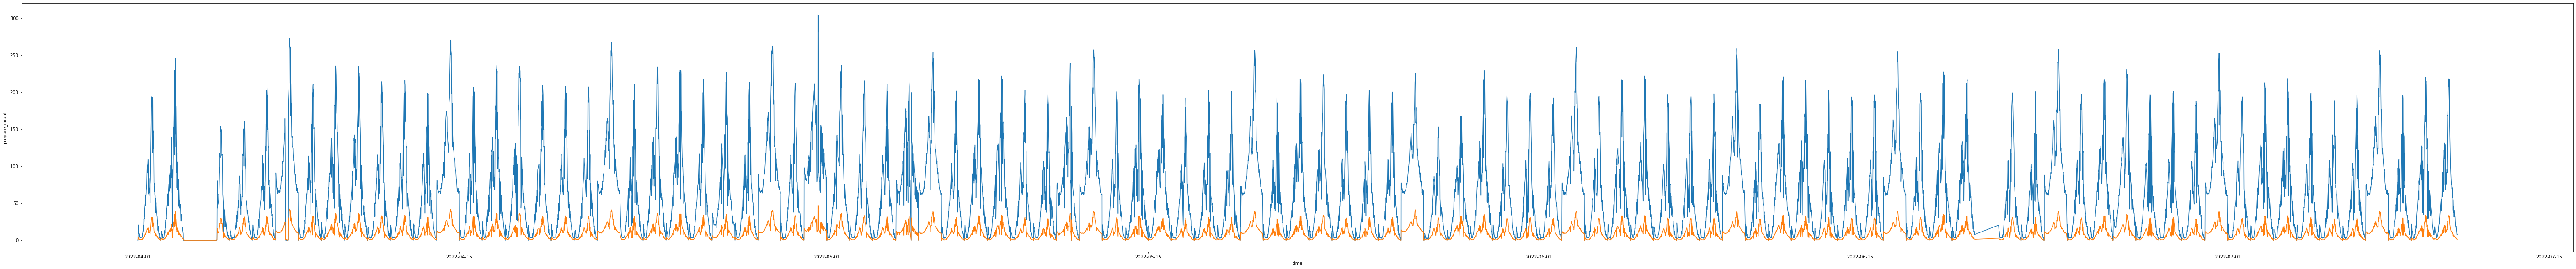

In [17]:
## draw lineplot with high corr time series data
time = pd.to_datetime(df_sampled.index)

# call_count, cpu_usage
plt.figure(figsize=(100,10))
sns.lineplot(data=df_sampled['call_count'], x=time, y=df_sampled['call_count'])
sns.lineplot(data=df_sampled['cpu_usage'], x=time, y=df_sampled['cpu_usage'])

# prepare_count, tps
plt.figure(figsize=(100,10))
sns.lineplot(data=df_sampled['prepare_count'], x=time, y=df_sampled['prepare_count'])
sns.lineplot(data=df_sampled['tps'], x=time, y=df_sampled['tps'])


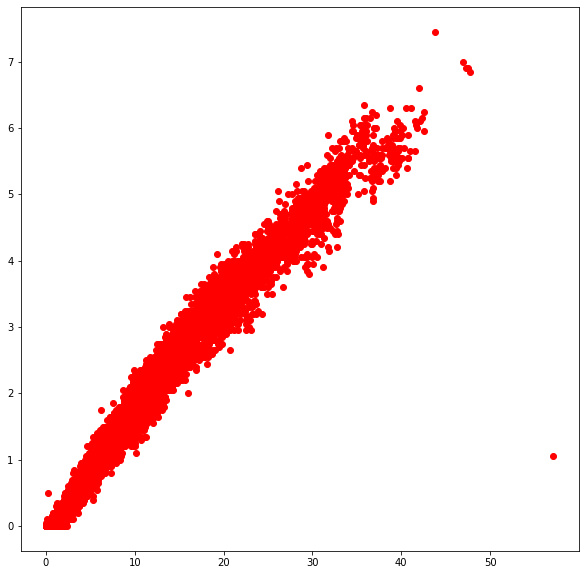

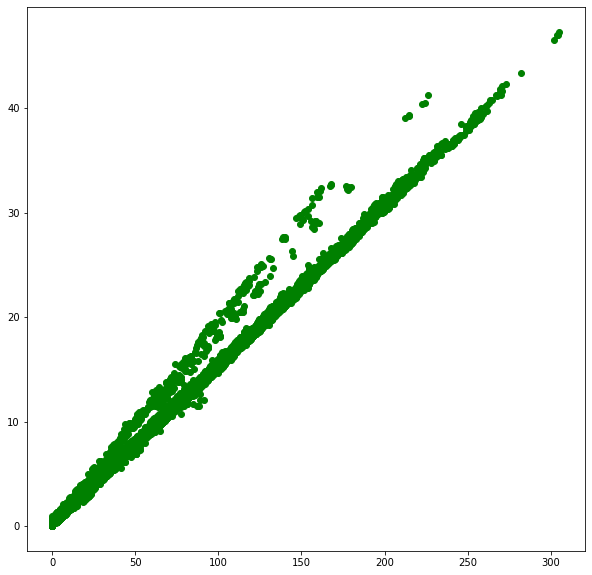

In [21]:
## simple scatter matrix with high corr metric pair

# call_count, cpu_usage
plt.figure(figsize=(10,10))
plt.scatter(df_sampled['call_count'], df_sampled['cpu_usage'], color='red')
plt.show()

# prepare_count, tps
plt.figure(figsize=(10,10))
plt.scatter(df_sampled['prepare_count'], df_sampled['tps'], color='green')
plt.show()
